In [1]:
from transformers import AutoModelWithLMHead,AutoTokenizer,pipeline, MarianTokenizer, MarianTokenizer, TFMarianMTModel, AutoModelForSeq2SeqLM
import torch
mode_name = '/data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model =AutoModelForSeq2SeqLM.from_pretrained(mode_name)
tokenizer = AutoTokenizer.from_pretrained(mode_name, return_tensors="pt")
from datasets import load_dataset, load_metric
raw_datasets = load_dataset("wmt17", "zh-en", cache_dir="/data2/hanyings/.cache")
metric = load_metric("sacrebleu")

/data2/hanyings/conda_envs/tnmt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-19 12:23:43.154644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 12:23:48.244695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64:$LD_LIBRARY_PATH
2023-03-19 12:23:48.245256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_l

In [2]:
input=tokenizer('I like dog.',return_tensors="pt").input_ids
outputs = model.generate(input, output_scores=True, return_dict_in_generate=True, output_hidden_states=True)
tokenizer.batch_decode(outputs['sequences'], skip_special_tokens=True)

['我喜欢狗。']

In [3]:
# get your batch data: token_id, mask and labels
token_ids = tokenizer('28-Year-Old Chef Found Dead at San Francisco Mall', return_tensors="pt").input_ids

with tokenizer.as_target_tokenizer():
    labels = tokenizer('28岁厨师被发现死于旧金山一家商场', return_tensors="pt").input_ids
# get your token embeddings
token_embeds=model.get_input_embeddings().weight[token_ids].clone()
token_embeds.retain_grad() 
# get model output that contains loss value
outs = model(inputs_embeds=token_embeds,labels=labels, output_hidden_states=True, output_attentions=True)
loss=outs.loss
loss

tensor(9.6922, grad_fn=<NllLossBackward0>)

In [4]:
loss.backward(retain_graph=True)
grad=token_embeds.grad
grad.size()

torch.Size([1, 15, 512])

In [5]:
grad

tensor([[[-5.4350e-03,  3.5752e-03, -3.4808e-03,  ..., -1.1933e-03,
          -7.5228e-03, -1.3361e-02],
         [-7.6200e-03,  2.5909e-03, -7.4903e-03,  ..., -4.5551e-03,
          -2.1150e-05, -2.0873e-02],
         [-5.2622e-03,  6.5888e-03, -1.3310e-02,  ..., -1.3901e-02,
           9.4895e-03, -2.1979e-02],
         ...,
         [-1.9948e-03,  3.7519e-03, -7.6046e-03,  ..., -1.6225e-03,
           2.5829e-03,  1.1196e-04],
         [-1.1796e-03,  1.5156e-03, -4.7933e-03,  ..., -2.8912e-03,
           1.9088e-03,  4.9598e-03],
         [ 2.6003e-03,  1.4686e-03, -7.5847e-03,  ..., -4.5510e-03,
           8.8066e-04,  5.4933e-03]]])

In [6]:
import torch
import numpy as np
idx = np.argsort(torch.norm(grad, dim=2).squeeze(dim=0)).tolist()[::-1][:15]

In [7]:
import string
input_tokens = [token_ids[0][i] for i in idx ]
[tokenizer.decode(t) for t in input_tokens]

['at',
 'Dead',
 'San',
 'Found',
 'Francisco',
 'Chef',
 'Year',
 '28',
 '-',
 'ld',
 'O',
 '</s>',
 'Ma',
 '-',
 'll']

In [2]:
raw_datasets['test'][:100]

{'translation': [{'en': '28-Year-Old Chef Found Dead at San Francisco Mall',
   'zh': '28岁厨师被发现死于旧金山一家商场'},
  {'en': 'A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.',
   'zh': '近日刚搬至旧金山的一位28岁厨师本周被发现死于当地一家商场的楼梯间。'},
  {'en': 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."',
   'zh': '但受害人的哥哥表示想不出有谁会想要加害于他，并称“一切终于好起来了。”'},
  {'en': "The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.",
   'zh': '旧金山验尸官办公室表示，周三早上于西田购物中心发现的尸体确认为28岁旧金山居民 Frank Galicia。'},
  {'en': 'The San Francisco Police Department said the death was ruled a homicide and an investigation is ongoing.',
   'zh': '旧金山警察局称该起死亡案件被裁定为他杀，并正在进行调查。'},
  {'en': "The victim's brother, Louis Galicia, told ABC station KGO in San Francisco that Frank, previousl

In [9]:
token_ids[0][1]
torch.norm(grad, dim=2).squeeze(dim=0)

tensor([0.1752, 0.1577, 0.1816, 0.1362, 0.1459, 0.1526, 0.1899, 0.2238, 0.2963,
        0.3084, 0.2635, 0.1921, 0.1419, 0.1250, 0.1448])

In [23]:
import re
from nltk.corpus import stopwords
import string 
import nltk
import numpy as np
nltk.download('stopwords')
sw_nltk = stopwords.words('english')
def is_stopword(token_id, tokenizer):
    word = tokenizer.decode(token_id)
    if word in string.punctuation:
        return True
    word = word.lower()
    word = re.sub(r'[^\w\s]', '', word)
    stopword = stopwords.words('english') + ["</s>", "<unk>", ">>cmn_Hans<<", "<pad>"]
    if word in stopword or not word:
        return True
    return False 
def gradient_search_nostop(en_sentence, zh_sentence, k=5):
    token_ids = tokenizer(en_sentence, return_tensors="pt").input_ids
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(zh_sentence, return_tensors="pt").input_ids
    # get your token embeddings
    token_embeds=model.get_input_embeddings().weight[token_ids].clone()
    token_embeds.retain_grad() 
    # get model output that contains loss value
    outs = model(inputs_embeds=token_embeds,labels=labels, output_hidden_states=True, output_attentions=True)
    loss=outs.loss
    loss.backward(retain_graph=True)
    grad=token_embeds.grad
    grad_norm = torch.norm(grad, dim=2).squeeze(dim=0)
    
    for i in range(len(token_ids[0])):
        current_token = token_ids[0][i]
        if is_stopword(current_token, tokenizer):
            grad_norm[i] = -1

    idx = np.argsort(grad_norm).tolist()[::-1][:k]
    idx =[ i for i in idx if not is_stopword(token_ids[0][i], tokenizer)]
    input_tokens = [token_ids[0][i] for i in idx ]
    return idx, [tokenizer.decode(t) for t in input_tokens if tokenizer.decode(t) not in string.punctuation]

def gradient_search(en_sentence, zh_sentence, k=5):
    token_ids = tokenizer(en_sentence, return_tensors="pt").input_ids
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(zh_sentence, return_tensors="pt").input_ids
    # get your token embeddings
    token_embeds=model.get_input_embeddings().weight[token_ids].clone()
    token_embeds.retain_grad() 
    # get model output that contains loss value
    outs = model(inputs_embeds=token_embeds,labels=labels, output_hidden_states=True, output_attentions=True)
    loss=outs.loss
    loss.backward(retain_graph=True)
    grad=token_embeds.grad
    grad_norm = torch.norm(grad, dim=2).squeeze(dim=0)
    
    # for i in range(len(token_ids[0])):
    #     current_token = token_ids[0][i]
    #     if is_stopword(current_token, tokenizer):
    #         grad_norm[i] = 0
    idx = np.argsort(grad_norm).tolist()[::-1][:k]
    
    input_tokens = [token_ids[0][i] for i in idx ]
    return idx, [tokenizer.decode(t) for t in input_tokens]
   

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/as/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def loop_data_nostop(dataset):
    for pair in dataset['translation']:
        pair["token_index"], pair["top_tokens"] = gradient_search_nostop(pair["en"], pair["zh"])
    return dataset['translation']
result = loop_data_nostop(raw_datasets["test"][:16])

In [25]:
result

[{'en': '28-Year-Old Chef Found Dead at San Francisco Mall',
  'zh': '28岁厨师被发现死于旧金山一家商场',
  'token_index': [8, 10, 7, 11, 6],
  'top_tokens': ['Dead', 'San', 'Found', 'Francisco', 'Chef']},
 {'en': 'A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.',
  'zh': '近日刚搬至旧金山的一位28岁厨师本周被发现死于当地一家商场的楼梯间。',
  'token_index': [1, 3, 21, 6, 22],
  'top_tokens': ['28', 'year', 'air', 'chef', 'well']},
 {'en': 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."',
  'zh': '但受害人的哥哥表示想不出有谁会想要加害于他，并称“一切终于好起来了。”',
  'token_index': [2, 21, 5, 6, 11],
  'top_tokens': ['victim', 'saying', 'brother', 'says', 'think']},
 {'en': "The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.",
  'zh': '旧金山验尸官办公室表示，周三早上于西田购物中心发现的尸体确认为28岁旧金山居民 Frank Galicia。

In [19]:
def loop_data(dataset):
    for pair in dataset['translation']:
        pair["token_index"], pair["top_tokens"] = gradient_search(pair["en"], pair["zh"])
    return dataset['translation']
result = loop_data(raw_datasets["test"][:100])

In [20]:
result

[{'en': '28-Year-Old Chef Found Dead at San Francisco Mall',
  'zh': '28岁厨师被发现死于旧金山一家商场',
  'token_index': [9, 8, 10, 7, 11],
  'top_tokens': ['at', 'Dead', 'San', 'Found', 'Francisco']},
 {'en': 'A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.',
  'zh': '近日刚搬至旧金山的一位28岁厨师本周被发现死于当地一家商场的楼梯间。',
  'token_index': [0, 1, 2, 3, 18],
  'top_tokens': ['A', '28', 'year', 'the']},
 {'en': 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."',
  'zh': '但受害人的哥哥表示想不出有谁会想要加害于他，并称“一切终于好起来了。”',
  'token_index': [0, 1, 2, 3, 4],
  'top_tokens': ['But', 'the', 'victim', 's']},
 {'en': "The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.",
  'zh': '旧金山验尸官办公室表示，周三早上于西田购物中心发现的尸体确认为28岁旧金山居民 Frank Galicia。',
  'token_index': [1, 4, 3, 0, 2]

In [21]:
import nltk
from collections import Counter
import matplotlib.pyplot as plt
nltk.download('averaged_perceptron_tagger')
#pos = nltk.pos_tag(result[0]["top_tokens"])
def count_pos(result_dict):
    all_tokens = []
    for sent in result_dict:
        all_tokens += sent["top_tokens"]
    pos = nltk.pos_tag(all_tokens)
    the_count = Counter(tag for _, tag in pos)
    
    labels, values = zip(*the_count.items())

    indexes = np.arange(len(labels))
    width = 1

    plt.title("Distribution of Tokens POS")
    plt.bar(indexes, values, width, color=(0.3, 0.4, 0.7, 0.6))
    plt.xticks(indexes + width * 0.5, labels, rotation=90)
    plt.show()
    return the_count

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/users/as/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


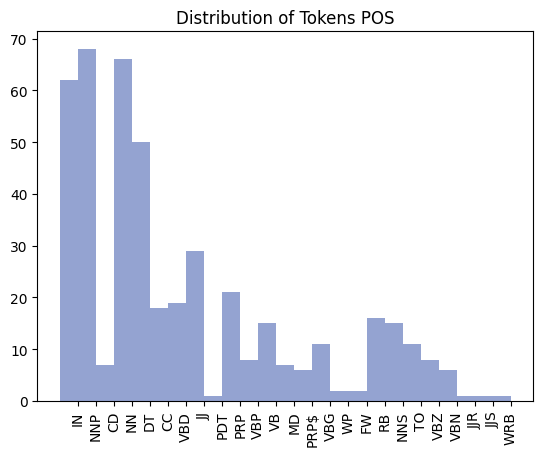

In [22]:
count = count_pos(result)